In [42]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pydst

Dst = pydst.Dst(lang='en')

In [43]:
projdata = Dst.get_data(table_id = 'FRDK218', variables={'HERKOMST':['*'],'BEVÆGELSE':['*'], 'TID':['*']})

In [56]:
proj_data=projdata.groupby(['BEVÆGELSE','TID'])['INDHOLD'].sum()
proj_data=proj_data.unstack(level=0)
proj_data.reset_index(inplace=True)
proj_data.drop(labels='Population increase', axis=1,inplace=True)

In [57]:
proj_data['Birth surplus']=proj_data['Livebirths']-proj_data['Deaths']
proj_data['Immigration surplus']=proj_data['Immigrated']-proj_data['Emigrated']
proj_data['Population growth']=proj_data['Birth surplus']+proj_data['Immigration surplus']
proj_data

BEVÆGELSE,TID,Deaths,Emigrated,Immigrated,Livebirths,Population primo,Birth surplus,Immigration surplus,Population growth
0,2018,53443,50522,72883,64179,5781190,10736,22361,33097
1,2019,53741,51555,70526,65293,5814283,11552,18971,30523
2,2020,54104,52194,68509,66378,5844805,12274,16315,28589
3,2021,54534,52535,67005,67497,5873392,12963,14470,27433
4,2022,55037,52717,65965,68718,5900824,13681,13248,26929
5,2023,55609,52816,65330,70005,5927751,14396,12514,26910
6,2024,56249,52885,64973,71140,5954662,14891,12088,26979
7,2025,56949,52947,64782,71915,5981643,14966,11835,26801
8,2026,57688,53016,64726,72332,6008444,14644,11710,26354
9,2027,58465,53091,64709,72492,6034797,14027,11618,25645


In [46]:
aar=[2020]
next_aar=aar[-1]
while next_aar<2060:
    next_aar=aar[-1]+5
    aar.append(next_aar)

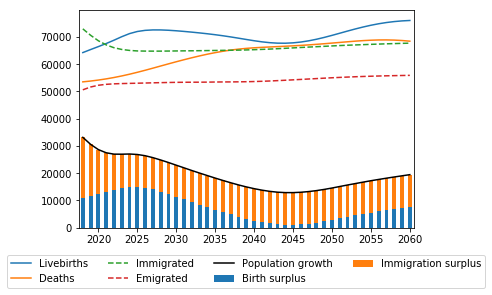

In [47]:
proj_data[['Birth surplus','Immigration surplus']].plot(kind='bar', stacked=True)
proj_data['Livebirths'].plot()
proj_data['Deaths'].plot()
proj_data['Immigrated'].plot(linestyle='dashed')
proj_data['Emigrated'].plot(linestyle='dashed')
proj_data['Population growth'].plot(color='k')
plt.xticks(np.arange(2,len(proj_data),5),aar)
plt.legend(bbox_to_anchor=(0.5, -0.3), loc=8, ncol=4)
plt.show()

Befolkningstal og relativ vækst

In [66]:
proj_data['Relative growth']=proj_data['Population primo'].pct_change()*100
proj_data['Average annual growth (2018-2060)']=((proj_data['Population primo'].iloc[-1]/proj_data['Population primo'].iloc[0])**(1/(2060-2018))-1)*100

BEVÆGELSE,TID,Deaths,Emigrated,Immigrated,Livebirths,Population primo,Birth surplus,Immigration surplus,Population growth,Relative growth,Average annual growth (2018-2060)
0,2018,53443,50522,72883,64179,5781190,10736,22361,33097,NaN,0.315224
1,2019,53741,51555,70526,65293,5814283,11552,18971,30523,0.572425,0.315224
2,2020,54104,52194,68509,66378,5844805,12274,16315,28589,0.524949,0.315224
3,2021,54534,52535,67005,67497,5873392,12963,14470,27433,0.489101,0.315224
4,2022,55037,52717,65965,68718,5900824,13681,13248,26929,0.467055,0.315224
5,2023,55609,52816,65330,70005,5927751,14396,12514,26910,0.456326,0.315224
6,2024,56249,52885,64973,71140,5954662,14891,12088,26979,0.453983,0.315224
7,2025,56949,52947,64782,71915,5981643,14966,11835,26801,0.453107,0.315224
8,2026,57688,53016,64726,72332,6008444,14644,11710,26354,0.448054,0.315224
9,2027,58465,53091,64709,72492,6034797,14027,11618,25645,0.438599,0.315224


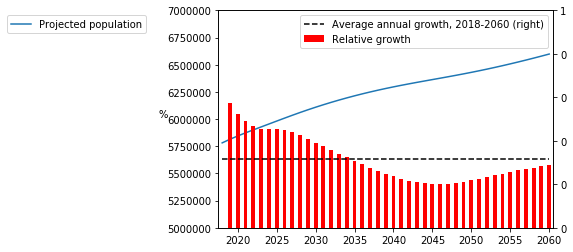

In [90]:
ax1=proj_data[['Relative growth']].plot(kind='bar', secondary_y=True,color='red',legend=False, label='Relative growth (right)')
ax2=proj_data['Average annual growth (2018-2060)'].plot(secondary_y=True,color='black',linestyle='dashed', label='Average annual growth, 2018-2060 (right)')
ax3=proj_data['Population primo'].plot(label = 'Projected population', legend=True)
plt.xticks(np.arange(2,len(proj_data),5),aar)
ax1.set_ylim(0, 1)
ax3.set_ylim(5000000, 7000000)
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax3.set_ylabel("%",rotation=0)
ax3.legend(bbox_to_anchor=(-0.2,1))
plt.legend()
plt.show()

Alderspyramide

In [7]:
agedist = Dst.get_data(table_id = 'FRDK118', variables={'HERKOMST':['*'],'KØN':['*'], 'ALDER':['*'], 'TID':['*']})

In [8]:
age_dist=agedist.groupby(['KØN','ALDER','TID'])['INDHOLD'].sum()
age_dist=age_dist.unstack(level=0)
age_dist.reset_index(inplace=True)
age_dist['Order'] = age_dist['ALDER'].map(lambda x: x.rstrip(' years'))
age_dist['Order']=age_dist['Order'].astype(int)
#age_dist.loc[:, 'Men'] = age_dist['Men'] * -1

In [9]:
alder_list=[0]
next_alder=alder_list[-1]
while next_alder<111:
    next_alder=alder_list[-1]+10
    alder_list.append(next_alder)

In [10]:
def agedist_plot(age_aar):
    agedist_fig=age_dist.loc[age_dist['TID']==age_aar].sort_values(by=['Order'])
    fig, axes = plt.subplots(ncols=2, sharey=False)
    axes[0].barh(agedist_fig['ALDER'], agedist_fig['Men'], align='center', color='blue')
    axes[0].set(title='Men')
    axes[1].barh(agedist_fig['ALDER'], agedist_fig['Women'], align='center', color='Red')
    axes[1].set(title='Women')
    axes[0].invert_xaxis()
    axes[0].set_xlim(50000)
    axes[1].set_xlim(0,50000)
    axes[1].yaxis.tick_right()
    axes[0].set(yticks=np.arange(0,110,10), yticklabels=agedist_fig['ALDER'][0:-2:10])
    axes[1].set(yticks=np.arange(0,110,10), yticklabels=agedist_fig['ALDER'][0:-2:10])
    fig.subplots_adjust(wspace=0)
    plt.show()
    return 

#interact(agedist_plot, age_aar = widgets.BoundedIntText(
#    age_aar=2018,
#    min=2018,
#    max=2058,
#    step=1,
#    description='Year:',
#    disabled=False
#))    

interact(agedist_plot, age_aar = widgets.IntSlider(value=2018, min=2018, max=2058, description='Year:', step=1))



interactive(children=(IntSlider(value=2018, description='Year:', max=2058, min=2018), Output()), _dom_classes=…

<function __main__.agedist_plot(age_aar)>